# [1D-BASELINE] Exp17: Robot Baseline Scan

## Import

In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
import datetime
import time
from IPython.display import clear_output

In [4]:
from grace.system import Grace
from grace.capture import LeftEyeCapture, RightEyeCapture
from grace.utils import get_center_chessboard_point, generate_triangle_wave

## Initialization

In [5]:
# Instantiation
grace = Grace(degrees=True)
left_cam = LeftEyeCapture()

[ROS Client] ROS Connection Successful at http://BodyNC-NUC:9090


In [6]:
# Experiment Helper Functions

def px_to_deg_fx(x):
    x = math.atan(x/581.0651)  # fx = 518.0651. fy = 581.0060
    x = math.degrees(x)
    return x

def save_pickle_data(data, camera: str, name: str):
    # Making Directory
    filename = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f") + "_" + camera + "_" + name
    filepath = os.path.join(os.path.abspath(".."), "results", filename)

    # Saving to Pickle File
    with open(filepath + ".pickle", 'wb') as file:
        pickle.dump(data, file)
    print('Data saved in:', filepath + ".pickle")
    return filepath + ".pickle"

def slow_reset():
    grace.slow_move_left_eye_pan(angle=-8, step_size=0.0879, time_interval=0.015)
    grace.slow_centering_eyes()
    
def generate_graphs(data, tilt, x_org):
    tilt_idx = tilt_arr.index(tilt)
    
    # Input Array
    plt.figure()
    input_arr  = data["input_arr"]
    plt.plot(input_arr)
    plt.ylim([-20, 20])
    plt.xlabel('Samples')
    plt.ylabel('Input Angle (deg)')
    plt.title('Input Motor Command')
    
    # Pixel vs Input Array (Raw)
    raw_x_pixel_arr = [x[0] for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, raw_x_pixel_arr, color='orange')
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Pixel X Value')
    plt.title('Raw Pixel Position')
    plt.grid()
    
    # Pixel vs Input Array (Raw)
    x_pixel_arr = [x_org-x[0] for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr, x_pixel_arr, color='orange')
    plt.xlabel('Input Angle (deg)')
    plt.ylabel('Delta Pixel X Value (wrt 320 px)')
    plt.title('Raw Pixel Position')
    plt.grid()
    
    # Time Series Eye Output vs Input Array
    phi = [px_to_deg_fx(x_org-x[0]) for x in data["pixel_arr"][tilt_idx]]
    plt.figure()
    plt.plot(input_arr)
    plt.plot(phi, color='orange')
    plt.xlabel('Samples')
    plt.ylabel('Angles (deg)')
    plt.ylim([-20, 20])
    plt.legend(['Input Command', 'Eye Output'])
    plt.title('Theta vs Phi')

    # Eye Output vs Input Array
    plt.figure()
    plt.plot(input_arr, phi, color="orange")
    plt.xlabel('Input Command')
    plt.ylabel('Eye Output')
    plt.title('Robot Data')
    plt.grid() 
    

['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0']


Text(0, 0.5, 'Input Angle (deg)')

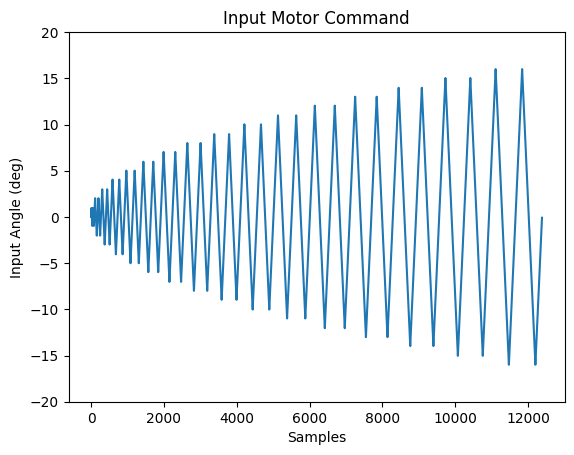

In [14]:
# Logarithmic Calculation

max_pan = 17
mult = 0.1
log_cmd = []
log_cmd_str = []

init_amp = 0
step_size = 0.0879
num_cycles = 2
include_init = 1
time_interval = 0.015  # sec

triangle_arr = []

for i in range(1):
    mult = mult*10
    for j in range(1,17):
        tmp = mult*j
        if tmp < max_pan:
            log_cmd.append(tmp)
            log_cmd_str.append("%.1f"%tmp)
            triangle_arr.extend(generate_triangle_wave(init_amp, -tmp, tmp, step_size, num_cycles, include_init)[:-1])
        else:
            break

print(log_cmd_str)

plt.title('Input Motor Command')
plt.plot(triangle_arr)
plt.ylim([-20, 20])
plt.xlabel('Samples')
plt.ylabel('Input Angle (deg)')

In [16]:
# Initialization

pickle_data = {
    "title": "[1D-BASELINE] Exp17: Robot Baseline Scan",
    "description": None,
    "data_label": ['0'],
    "data": None,
    "datetime": datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f")
}

data_list = []

data = {
    "tilt_arr": [],  # Designated tilt of the pan sweep
    "input_cmd": [],  # Data points or Triangle Wave
    "pixel_data": [],  # row: tilt value, column: pan value
    "initial_motor_state": [],  # Motor state before experiment
    "initial_pixel_state": [],  # Pixel state before experiment
    "end_motor_state": [],  # Motor state after experiment
    "end_pixel_state": []  # Pixel state after experiment
}

In [8]:
# Center the left eye

grace.slow_centering_eyes()

(0.0, 0.0)

## EXP1.1. Multiple Amplitude

In [21]:
# Initialize Data

data = {
    "tilt_arr": [],  # Designated tilt of the pan sweep
    "input_arr": [],  # Data points or Triangle Wave
    "pixel_arr": [],  # row: tilt value, column: pan value
    "initial_motor_state": [],  # Motor state before experiment
    "initial_pixel_state": [],  # Pixel state before experiment
    "end_motor_state": [],  # Motor state after experiment
    "end_pixel_state": []  # Pixel state after experiment
}

input_arr = triangle_arr
tilt_arr = [0]

In [22]:
# Experiment Sweep

data["tilt_arr"] = tilt_arr
data["input_arr"] = input_arr

start = time.time()

# Initial State
slow_reset()
time.sleep(0.75)
data["initial_motor_state"].append(grace.state)
data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame))

cnt = 0
for tilt in tilt_arr:
    pixel_arr = []
    for pan in input_arr:
        cnt+=1
        clear_output(wait=True)
        grace.direct_move_left_eye((pan, None))
        time.sleep(time_interval)
        
        in_cnt = 0
        while(in_cnt < 5):
            try:
                pixel_pt = get_center_chessboard_point(left_cam.frame)
            except:
                pass
            else:
                break
            in_cnt+=1
        pixel_arr.append(pixel_pt)
        print(f"{cnt}/{len(input_arr)*len(tilt_arr)}")
        print(f"pan:{pan}, tilt:{tilt}")
    data["pixel_arr"].append(pixel_arr)

# End State
slow_reset()
time.sleep(0.75)
data["initial_motor_state"].append(grace.state)
data["initial_pixel_state"].append(get_center_chessboard_point(left_cam.frame)) 
    
print("Elapsed Time:", time.time()-start)

12384/12384
pan:-0.0879, tilt:0
Elapsed Time: 427.59112906455994


In [23]:
# Checking of Data

data["pixel_arr"]

[[[317.15753173828125, 238.52407836914062],
  [317.15753173828125, 238.52407836914062],
  [317.13043212890625, 238.53314208984375],
  [317.13043212890625, 238.53314208984375],
  [316.96728515625, 238.5337677001953],
  [316.96728515625, 238.5337677001953],
  [314.69970703125, 238.52528381347656],
  [314.69970703125, 238.52528381347656],
  [312.9774475097656, 238.58416748046875],
  [312.9774475097656, 238.58416748046875],
  [312.9774475097656, 238.58416748046875],
  [310.4970397949219, 238.54811096191406],
  [308.6767883300781, 238.54563903808594],
  [308.6767883300781, 238.54563903808594],
  [305.96820068359375, 238.50222778320312],
  [305.96820068359375, 238.50222778320312],
  [305.750244140625, 238.46435546875],
  [305.750244140625, 238.46435546875],
  [305.8171081542969, 238.43679809570312],
  [305.8171081542969, 238.43679809570312],
  [305.8171081542969, 238.43679809570312],
  [305.86981201171875, 238.4327850341797],
  [305.86981201171875, 238.4327850341797],
  [305.8812255859375, 2

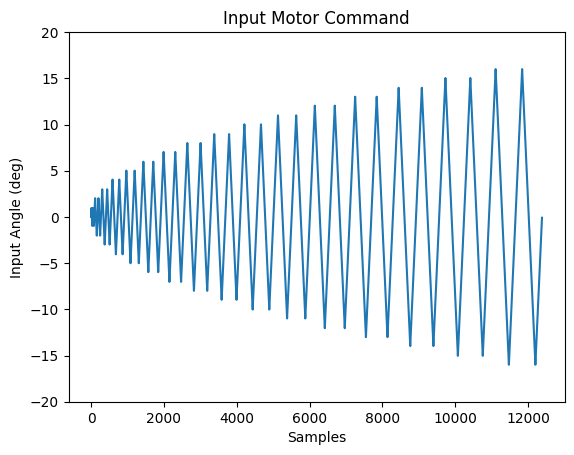

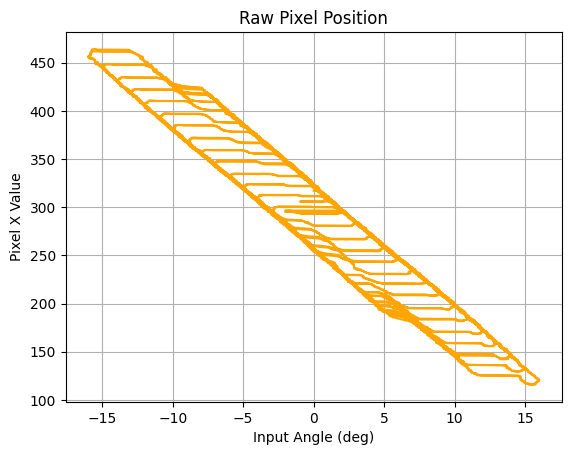

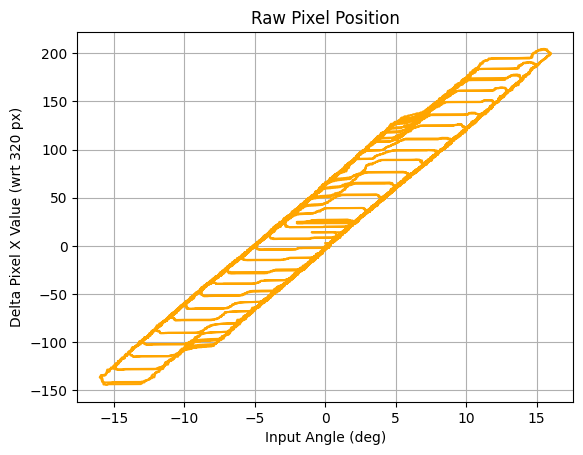

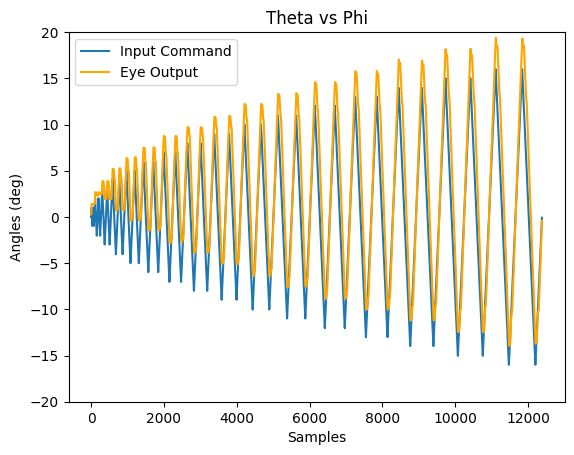

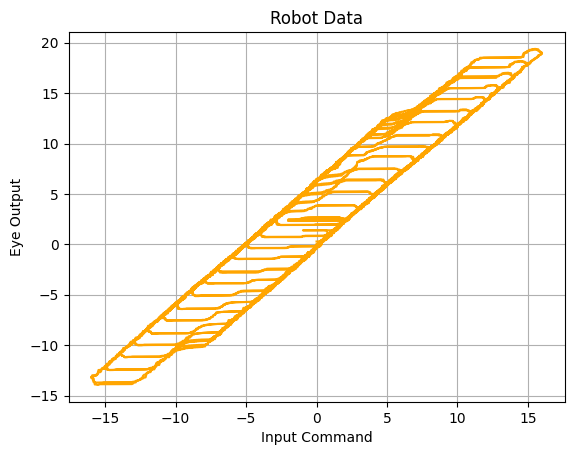

In [24]:
# Graphs Generation

generate_graphs(data, tilt=0.0, x_org=320)

In [25]:
# Appending to Data List

data_list.append(data)

# Saving the Data

In [26]:
pickle_data["data"] = data_list
data_filepath = save_pickle_data(pickle_data, camera="left", name="1D-BASELINE_EXP17_RobotBaselineScan")

Data saved in: C:\dev\robot_control\results\20230222_230506_128056_left_1D-BASELINE_EXP17_RobotBaselineScan.pickle


# Loading the Data

In [27]:
# Opening of Pickle File

with open(data_filepath, 'rb') as file:
    data_load = pickle.load(file)

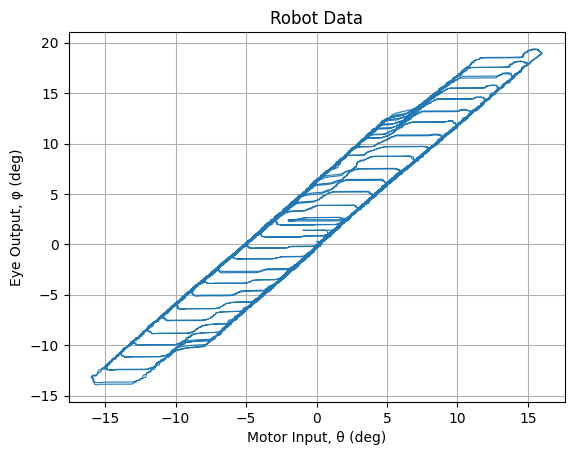

In [35]:
# Data Superposition

%matplotlib inline

# Time Series Eye Output vs Input Array
x_org = 320
tilt_idx = 0

for i in range(len(data_load["data_label"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x_org-x[0]) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, linewidth=0.8)
    
plt.xlabel('Motor Input, θ (deg)')
plt.ylabel('Eye Output, φ (deg)')
plt.title('Robot Data')
plt.grid()

In [34]:
%matplotlib qt

# Data Superposition

# Time Series Eye Output vs Input Array
x_org = 320
tilt_idx = 0

for i in range(len(data_load["data_label"])):
    input_arr = data_load["data"][i]["input_arr"]
    phi = [px_to_deg_fx(x_org-x[0]) for x in data_load["data"][i]["pixel_arr"][tilt_idx]]

    # Eye Output vs Input Array
    plt.plot(input_arr, phi, linewidth=1.0)
    
plt.xlabel('Motor Input, θ (deg)')
plt.ylabel('Eye Output, φ (deg)')
plt.title('Robot Data')
plt.grid()

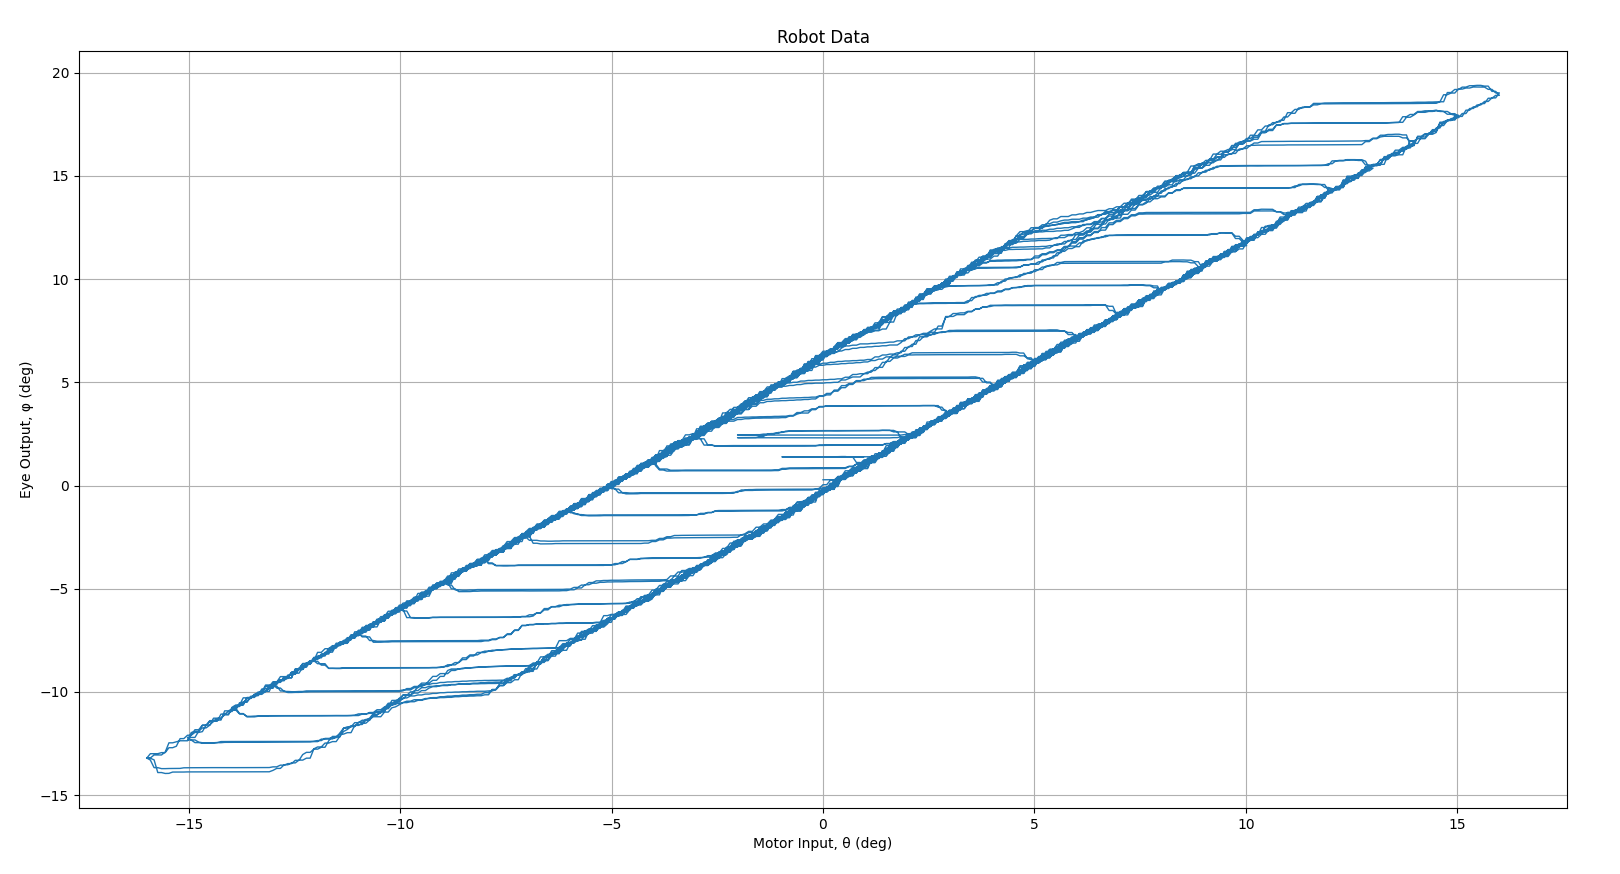